In [8]:
import numpy as np
import emoji 
import matplotlib.pyplot as plt
import csv

In [89]:
def read_csv(filename = 'data/emojify_data.csv'):
    phrase = []
    emoji = []

    with open (filename) as csvDataFile:
        csvReader = csv.reader(csvDataFile)

        for row in csvReader:
            phrase.append(row[0])
            emoji.append(row[1])

    X = np.asarray(phrase)
    Y = np.asarray(emoji, dtype=int)

    return X, Y


emoji_dictionary = {"0": "\u2764\ufe0f",
                    "1": "\U0001F3BE",
                    "2": "\U0001F603",
                    "3": "\U0001F61E",
                    "4": "\U0001F374"}

def label_to_emoji(label):
    return emoji_dictionary[str(label)]

for label, emoji in emoji_dictionary.items():
    print(label_to_emoji(label))

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

❤️
🎾
😃
😞
🍴


In [73]:
X_train, Y_train = read_csv('emojidata/train_emoji.csv')
X_test, Y_test = read_csv('emojidata/test_emoji.csv')

maxLen = len(max(X_train, key=len).split())
for idx in range(10):
    print(X_train[idx], label_to_emoji(Y_train[idx]))

never talk to me again 😞
I am proud of your achievements 😃
It is the worst day in my life 😞
Miss you so much ❤️
food is life 🍴
I love you mum ❤️
Stop saying bullshit 😞
congratulations on your acceptance 😃
The assignment is too long  😞
I want to go play 🎾


In [75]:
Y_oh_train = convert_to_one_hot(Y_train, C = 5)
Y_oh_test = convert_to_one_hot(Y_test, C = 5)
idx = 50
print(f"Sentence '{X_train[50]}' has label index {Y_train[idx]}", f"which is emoji {label_to_emoji(Y_train[idx])}")
print(f"Label index {Y_train[idx]} in one-hot encoding format is {Y_oh_train[idx]}")

Sentence 'I missed you' has label index 0 which is emoji ❤️
Label index 0 in one-hot encoding format is [1. 0. 0. 0. 0.]


In [78]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('datasets/glove.6B.50d.txt')

In [80]:
word = "cucumber"
idx = 289846
print("the index of", word, "in the vocabulary is", word_to_index[word])
print("the", str(idx) + "th word in the vocabulary is", index_to_word[idx])


the index of cucumber in the vocabulary is 113317
the 289846th word in the vocabulary is potatos


In [81]:
def sentence_to_avg(sentence, word_to_vec_map):
    any_word = list(word_to_vec_map.keys())[0]
    words = sentence.lower().split()
    avg = np.zeros(word_to_vec_map[any_word].shape)
    count = 0 
    for w in words:
        if w in list(word_to_vec_map.keys()): 
            avg += word_to_vec_map[w]
            count += 1
    if count > 0:
        avg = avg / count 
    return avg

In [88]:
avg = sentence_to_avg("Morrocan couscous is my favorite dish", word_to_vec_map)
print("avg = \n", avg)


avg = 
 [-0.008005    0.56370833 -0.50427333  0.258865    0.55131103  0.03104983
 -0.21013718  0.16893933 -0.09590267  0.141784   -0.15708967  0.18525867
  0.6495785   0.38371117  0.21102167  0.11301667  0.02613967  0.26037767
  0.05820667 -0.01578167 -0.12078833 -0.02471267  0.4128455   0.5152061
  0.38756167 -0.898661   -0.535145    0.33501167  0.68806933 -0.2156265
  1.797155    0.10476933 -0.36775333  0.750785    0.10282583  0.348925
 -0.27262833  0.66768    -0.10706167 -0.283635    0.59580117  0.28747333
 -0.3366635   0.23393817  0.34349183  0.178405    0.1166155  -0.076433
  0.1445417   0.09808667]


In [92]:
def predict(X, Y, W, b, word_to_vec_map):
    m = X.shape[0]
    pred = np.zeros((m, 1))
    any_word = list(word_to_vec_map.keys())[0]
    n_h = word_to_vec_map[any_word].shape[0] 
    for j in range(m):
        words = X[j].lower().split()
        avg = np.zeros((n_h,))
        count = 0
        for w in words:
            if w in word_to_vec_map:
                avg += word_to_vec_map[w]
                count += 1
        if count > 0:
            avg = avg / count
        Z = np.dot(W, avg) + b
        A = softmax(Z)
        pred[j] = np.argmax(A)
    print("Accuracy: "  + str(np.mean((pred[:] == Y.reshape(Y.shape[0],1)[:]))))
    return pred


def model(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 200):
    """
    Model to train word vector representations in numpy.
    
    Arguments:
    X -- input data, numpy array of sentences as strings, of shape (m, 1)
    Y -- labels, numpy array of integers between 0 and 7, numpy-array of shape (m, 1)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    learning_rate -- learning_rate for the stochastic gradient descent algorithm
    num_iterations -- number of iterations
    
    Returns:
    pred -- vector of predictions, numpy-array of shape (m, 1)
    W -- weight matrix of the softmax layer, of shape (n_y, n_h)
    b -- bias of the softmax layer, of shape (n_y,)
    """
    
    # Get a valid word contained in the word_to_vec_map 
    any_word = list(word_to_vec_map.keys())[0]
        
    # Initialize cost. It is needed during grading
    cost = 0
    
    # Define number of training examples
    m = Y.shape[0]                             # number of training examples
    n_y = len(np.unique(Y))                    # number of classes  
    n_h = word_to_vec_map[any_word].shape[0]   # dimensions of the GloVe vectors 
    
    # Initialize parameters using Xavier initialization
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,))
    
    # Convert Y to Y_onehot with n_y classes
    Y_oh = convert_to_one_hot(Y, C = n_y) 
    
    # Optimization loop
    for t in range(num_iterations): # Loop over the number of iterations
        for i in range(m):          # Loop over the training examples
            
            ### START CODE HERE ### (≈ 4 lines of code)
            # Average the word vectors of the words from the i'th training example
            avg = sentence_to_avg(X[i], word_to_vec_map)

            # Forward propagate the avg through the softmax layer
            z = np.add(np.dot(W,avg),b)
            a = softmax(z)

            # Compute cost using the i'th training label's one hot representation and "A" (the output of the softmax)
            cost = -np.sum(np.dot(Y_oh[i], np.log(a)))
            ### END CODE HERE ###
            
            # Compute gradients 
            dz = a - Y_oh[i]
            dW = np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
            db = dz

            # Update parameters with Stochastic Gradient Descent
            W = W - learning_rate * dW
            b = b - learning_rate * db
        
        if t % 10 == 0:
            print("Epoch: " + str(t) + " --- cost = " + str(cost))
            pred = predict(X, Y, W, b, word_to_vec_map) #predict is defined in emo_utils.py

    return pred, W, b

In [93]:
pred, W, b = model(X_train, Y_train, word_to_vec_map)
print(pred)

Epoch: 0 --- cost = 1.864651019160555
Accuracy: 0.45454545454545453
Epoch: 10 --- cost = 0.9024757179755856
Accuracy: 0.7575757575757576
Epoch: 20 --- cost = 0.484798356756129
Accuracy: 0.7803030303030303
Epoch: 30 --- cost = 0.30265440959149736
Accuracy: 0.7954545454545454
Epoch: 40 --- cost = 0.2122654765980176
Accuracy: 0.8181818181818182
Epoch: 50 --- cost = 0.1615210985609624
Accuracy: 0.8560606060606061
Epoch: 60 --- cost = 0.13017043694575414
Accuracy: 0.8787878787878788
Epoch: 70 --- cost = 0.10934577304058635
Accuracy: 0.8787878787878788
Epoch: 80 --- cost = 0.09472272530884174
Accuracy: 0.9015151515151515
Epoch: 90 --- cost = 0.08399792095486905
Accuracy: 0.9242424242424242
Epoch: 100 --- cost = 0.07585322823985069
Accuracy: 0.9318181818181818
Epoch: 110 --- cost = 0.06948873316766034
Accuracy: 0.9318181818181818
Epoch: 120 --- cost = 0.06439501477754485
Accuracy: 0.9318181818181818
Epoch: 130 --- cost = 0.060234475375187474
Accuracy: 0.9318181818181818
Epoch: 140 --- cost = 

In [97]:
print("Training set:")
pred_train = predict(X_train, Y_train, W, b, word_to_vec_map)
print('Test set:')
pred_test = predict(X_test, Y_test, W, b, word_to_vec_map)

def predict_single(sentence, W=W, b=b, word_to_vec_map=word_to_vec_map):

    any_word = list(word_to_vec_map.keys())[0]
    # number of classes  
    n_h = word_to_vec_map[any_word].shape[0] 

    # Split jth test example (sentence) into list of lower case words
    words = sentence.lower().split()

    # Average words' vectors
    avg = np.zeros((n_h,))
    count = 0
    for w in words:
        if w in word_to_vec_map:
            avg += word_to_vec_map[w]
            count += 1

    if count > 0:
        avg = avg / count

    # Forward propagation
    Z = np.dot(W, avg) + b
    A = softmax(Z)
    pred = np.argmax(A)

    return pred

label_to_emoji(predict_single("I love you"))

Training set:
Accuracy: 0.9621212121212122
Test set:
Accuracy: 0.6071428571428571


'❤️'

In [96]:
X_my_sentences = np.array(["i adore you", "i love you", "funny lol", "lets play with a ball", "food is ready", "not feeling happy", "I hate you"])
Y_my_labels = np.array([[0], [0], [2], [1], [4],[3]])

pred = predict(X_my_sentences, Y_my_labels , W, b, word_to_vec_map)

def print_predictions(X, pred):
    print()
    for i in range(X.shape[0]):
        print(X[i], label_to_emoji(int(pred[i])))

print_predictions(X_my_sentences, pred)

Accuracy: 0.0

i adore you ❤️
i love you ❤️
funny lol 😃
lets play with a ball 🎾
food is ready 🍴
not feeling happy 😃
I hate you 😞


C:\Users\nq9093\AppData\Local\Temp\ipykernel_7560\2635300693.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  print("Accuracy: "  + str(np.mean((pred[:] == Y.reshape(Y.shape[0],1)[:]))))


(56,)
           ❤️    🎾    😃    😞   🍴
Predicted  0.0  1.0  2.0  3.0  4.0  All
Actual                                 
0            5    1    4    2    0   12
1            0    5    0    0    0    5
2            2    2   11    3    0   18
3            1    1    3    9    1   15
4            0    0    1    1    4    6
All          8    9   19   15    5   56


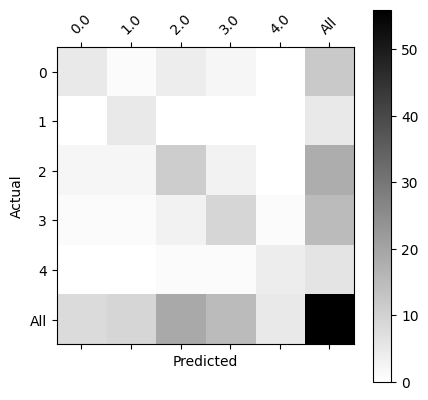

In [102]:
import pandas as pd
def plot_confusion_matrix(y_actu, y_pred, title='Confusion matrix', cmap=plt.cm.gray_r):
    
    df_confusion = pd.crosstab(y_actu, y_pred.reshape(y_pred.shape[0],), rownames=['Actual'], colnames=['Predicted'], margins=True)
    
    df_conf_norm = df_confusion / df_confusion.sum(axis=1)
    
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)
    

print(Y_test.shape)
print('           '+ label_to_emoji(0)+ '    ' + label_to_emoji(1) + '    ' +  label_to_emoji(2)+ '    ' + label_to_emoji(3)+'   ' + label_to_emoji(4))
print(pd.crosstab(Y_test, pred_test.reshape(56,), rownames=['Actual'], colnames=['Predicted'], margins=True))

plot_confusion_matrix(Y_test, pred_test)


In [103]:
import numpy as np
import tensorflow
np.random.seed(0)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
np.random.seed(1)

In [104]:
for idx, val in enumerate(["I", "like", "learning"]):
    print(idx, val)

0 I
1 like
2 learning


In [105]:
def sentences_to_indices(X, word_to_index, max_len):
    m = X.shape[0]                                   
    X_indices = np.zeros((m, max_len))
    for i in range(m):                               
        sentence_words = X[i].lower().split()
        j = 0
        for w in sentence_words:
            X_indices[i, j] = word_to_index[w]
            j = j + 1
    return X_indices

In [109]:
X1 = np.array(["funny lol", "lets play baseball", "food is ready for you"])
X1_indices = sentences_to_indices(X1, word_to_index, max_len=5)
print("X1 =", X1)
print("X1_indices =\n", X1_indices)

X1 = ['funny lol' 'lets play baseball' 'food is ready for you']
X1_indices =
 [[155345. 225122.      0.      0.      0.]
 [220930. 286375.  69714.      0.      0.]
 [151204. 192973. 302254. 151349. 394475.]]


In [110]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    vocab_len = len(word_to_index) + 1                  
    emb_dim = word_to_vec_map["cucumber"].shape[0]      
    emb_matrix = np.zeros((vocab_len, emb_dim))
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)
    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matrix])
    return embedding_layer

In [111]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][1] =", embedding_layer.get_weights()[0][1][1])
print("Input_dim", embedding_layer.input_dim)
print("Output_dim",embedding_layer.output_dim)

weights[0][1][1] = 0.39031
Input_dim 400001
Output_dim 50


In [112]:
def EmojifyLSTM(input_shape, word_to_vec_map, word_to_index):
    sentence_indices = Input(input_shape, dtype='int32')
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    embeddings = embedding_layer(sentence_indices)   
    X = LSTM(128, return_sequences=True)(embeddings)
    X = Dropout(0.5)(X)
    X = LSTM(128, return_sequences=False)(X)
    X = Dropout(0.5)(X)
    X = Dense(5)(X)
    X = Activation('softmax')(X)
    model = Model(inputs=sentence_indices, outputs=X)
    return model

In [113]:
model = EmojifyLSTM((maxLen,), word_to_vec_map, word_to_index)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 10, 50)            20000050  
                                                                 
 lstm (LSTM)                 (None, 10, 128)           91648     
                                                                 
 dropout (Dropout)           (None, 10, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 5)                 645   

In [114]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [115]:
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
Y_train_oh = convert_to_one_hot(Y_train, C = 5)

model.fit(X_train_indices, Y_train_oh, epochs = 100, batch_size = 32, shuffle=True)

Epoch 1/100
5/5 [==============================] - 2s 12ms/step - loss: 1.5785 - accuracy: 0.2348
Epoch 2/100
5/5 [==============================] - 0s 10ms/step - loss: 1.4845 - accuracy: 0.3788
Epoch 3/100
5/5 [==============================] - 0s 10ms/step - loss: 1.4420 - accuracy: 0.3030
Epoch 4/100
5/5 [==============================] - 0s 10ms/step - loss: 1.3647 - accuracy: 0.4318
Epoch 5/100
5/5 [==============================] - 0s 10ms/step - loss: 1.2384 - accuracy: 0.5530
Epoch 6/100
5/5 [==============================] - 0s 10ms/step - loss: 1.0922 - accuracy: 0.5606
Epoch 7/100
5/5 [==============================] - 0s 10ms/step - loss: 0.9496 - accuracy: 0.6667
Epoch 8/100
5/5 [==============================] - 0s 10ms/step - loss: 0.8656 - accuracy: 0.6667
Epoch 9/100
5/5 [==============================] - 0s 10ms/step - loss: 0.8408 - accuracy: 0.6742
Epoch 10/100
5/5 [==============================] - 0s 10ms/step - loss: 0.6896 - accuracy: 0.7803
Epoch 11/100
5/5 [=

In [116]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
Y_test_oh = convert_to_one_hot(Y_test, C = 5)
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)

2/2 [==============================] - 0s 4ms/step - loss: 2.4266 - accuracy: 0.6071

Test accuracy =  0.6071428656578064


In [117]:
# This code allows you to see the mislabelled examples
C = 5
y_test_oh = np.eye(C)[Y_test.reshape(-1)]
X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
pred = model.predict(X_test_indices)
for i in range(len(X_test)):
    x = X_test_indices
    num = np.argmax(pred[i])
    if(num != Y_test[i]):
        print('Expected emoji:'+ label_to_emoji(Y_test[i]) + ' prediction: '+ X_test[i] + label_to_emoji(num).strip())

2/2 [==============================] - 0s 3ms/step
Expected emoji:😃 prediction: he got a raise	😞
Expected emoji:❤️ prediction: she got me a present	😃
Expected emoji:❤️ prediction: he is a good friend	😃
Expected emoji:❤️ prediction: I am upset	😞
Expected emoji:❤️ prediction: We had such a lovely dinner tonight	😃
Expected emoji:😞 prediction: This girl is messing with me	❤️
Expected emoji:😃 prediction: are you serious ha ha	😞
Expected emoji:😞 prediction: stop messing around	🎾
Expected emoji:❤️ prediction: I love taking breaks	😞
Expected emoji:😞 prediction: she is a bully	❤️
Expected emoji:😞 prediction: I worked during my birthday	😃
Expected emoji:😃 prediction: enjoy your break	🎾
Expected emoji:❤️ prediction: valentine day is near	😃
Expected emoji:🍴 prediction: I am starving	😞
Expected emoji:😃 prediction: I will go dance🎾
Expected emoji:😃 prediction: I like your jacket 	❤️
Expected emoji:🎾 prediction: what is your favorite baseball game	❤️
Expected emoji:😃 prediction: I want to joke	😞
Expe

In [124]:
x_test = np.array(["I am not feeling happy"])
X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
print(x_test[0] +' '+  label_to_emoji(np.argmax(model.predict(X_test_indices))))

1/1 [==============================] - 0s 14ms/step
I am not feeling happy 😞
